# 傾向スコア

## バランシングスコア

**バランシングスコア**（balancing score）$b(\boldsymbol{x})$とは、$b(\boldsymbol{x})$が条件付けられた下での共変量$\boldsymbol{x}$の分布が処置$z$と独立になる（処置群$(z=1)$と対照群$(z=0)$とで$x$の条件付き分布が等しくなる）ような関数である（[Rosenbaum & Rubin, 1983](https://academic.oup.com/biomet/article/70/1/41/240879)）。

$$
\newcommand{\b}[1]{\boldsymbol{#1}}
\newcommand{\indep}{\perp\!\!\!\perp}
\b{x} \indep z | b(\b{x})
$$

共変量$\boldsymbol{x}$自身は最も細かい（finest）バランシングスコアであり、傾向スコア$P(z=1|\boldsymbol{x})$は最も粗い（coarsest）バランシングスコアである。



## 傾向スコア

共変量$\b{x}_i$の下でその対象$i$が処置される確率

$$
e_i = P(z_i = 1| \b{x}_i)
$$

を**傾向スコア**（propensity score）という。


### 傾向スコアの使用方法

1. **マッチング**：傾向スコアの値が同じ（厳密マッチング）か近い（最近傍マッチング）個体を比較する
2. **層別解析**：傾向スコアの値によっていくつかのサブクラスに分け、各クラスで処置群と対照群の平均をとって全体のATEを推定する
3. **回帰分析・共分散分析**：割当変数$z$と傾向スコア$e$を説明変数とした線形の回帰分析を行う
4. **その他の推定量**：IPW推定量やDR推定量など（後述）


### 傾向スコアの長所

1. 共変量を1次元に次元削減しているため、2つの群において共変量の値に重なりが少ない場合でも使える
2. 共変量と結果変数のモデル設定を行わなくてもよい
    - 例えば回帰分析のような線形モデルを構築しなくてもよい → 共変量と結果変数の間に線形性を仮定できない場合でも使える可能性
3. モデルの誤設定に強い
    - 共分散分析やロジスティック回帰により$E[y|x]$を直接モデリングする方法と、層別による傾向スコア解析を比較したところ、傾向スコア解析のほうがモデルの誤設定から生じるバイアスがより少なかったという研究がある（Drake, 1993）


## 傾向スコアマッチング

[causallib](https://causallib.readthedocs.io/en/latest/causallib.html)パッケージを使うと簡単に実装できる

参考：[causallib/examples/matching.ipynb at master · BiomedSciAI/causallib](https://github.com/BiomedSciAI/causallib/blob/master/examples/matching.ipynb)

In [10]:
# サンプルデータ
from causallib.datasets import load_nhefs
data = load_nhefs()
X, a, y = data.X, data.a, data.y  # 共変量X、割当a、結果y
data.descriptors

Variable name
active            IN YOUR USUAL DAY, HOW ACTIVE ARE YOU? IN 1971...
age                                                     AGE IN 1971
education         AMOUNT OF EDUCATION BY 1971: 1: 8TH GRADE OR L...
exercise          IN RECREATION, HOW MUCH EXERCISE? IN 1971, 0:m...
race                             0: WHITE 1: BLACK OR OTHER IN 1971
sex                                               0: MALE 1: FEMALE
smokeintensity          NUMBER OF CIGARETTES SMOKED PER DAY IN 1971
smokeyrs                                           YEARS OF SMOKING
wt71                                   WEIGHT IN KILOGRAMS  IN 1971
qsmk              QUIT SMOKING BETWEEN 1ST QUESTIONNAIRE AND 198...
wt82_71                                  WEIGHT CHANGE IN KILOGRAMS
Name: Description, dtype: object

In [29]:
# ロジスティック回帰でpropensity scoreを計算する
from sklearn.linear_model import LogisticRegression
learner = LogisticRegression(solver="liblinear", class_weight="balanced")

from causallib.estimation import PropensityMatching

pm = PropensityMatching(learner)
pm.fit(X, a, y)

# 処置ごとの平均の結果
outcomes = pm.estimate_population_outcome(X, a)
effect = pm.estimate_effect(outcomes[1], outcomes[0])
print(f"ATE={effect.iloc[0]:.3f}")

ATE=2.956


## 層別解析

傾向スコアの値に応じて、分析対象を$K$個（例えば5つ）の部分集合に分け、各クラスで処置群と対照群の結果変数の平均を計算し、それらの加重平均を全体の推定量とする

$$
\hat{\tau}_{SA} = \sum_{k=1}^K
\frac{N_k}{N} ( \bar{y}_{1k} - \bar{y}_{0k} )
$$

## IPW推定量

**逆確率重み付け**（inverse probability weighting: IPW）による推定量（Rubin, 1985）

$$
\begin{align}
\hat{E}(y_1) &= \sum^N_{i=1} \frac{z_i y_i}{e_i} / \sum^N_{i=1} \frac{z_i}{e_i}\\
\hat{E}(y_0) &= \sum^N_{i=1} \frac{(1-z_i) y_i}{1 - e_i} / \sum^N_{i=1} \frac{1 - z_i}{1 - e_i}\\
\end{align}
$$

によって各群の結果変数の期待値を推定でき、両者の差分でATEを推定できることが知られている。

なお、分子において$z_i y_i$のように処置変数$z_i$を乗じているのは処置群を取り出すため。重みを

$$
w_i = \frac{ z_i }{ e_i } + \frac{ 1 - z_i }{ 1 - e_i }
$$

と考えればわかりやすいかもしれない。たとえば個体$i$が処置群なら$z_i = 1$となり第一項だけが残り、

$$
y_i w_i = y_i \frac{1}{e_i}
$$

となる。

**導出**

真の傾向スコアの値が既知で、「強く無視できる割り当て」条件が成立するなら、

$$
\begin{align}
E(y_1)
&= E_{\b{x}}[E(y_1|\b{x})]\\
&= E_{\b{x}}\left[ E\left( \frac{z}{e} |\b{x} \right) E(y_1|\b{x}) \right]
\hspace{1em} (\because E(z/e) = E(z)/e = e/e = 1 )
\\
&= E_{\b{x}}\left[ E\left( \frac{z}{e} y_1|\b{x} \right) \right]\\
&= E\left( \frac{z y_1 }{e} \right)\\
&= E\left( \frac{z^2 y_1 + z (1-z) y_0}{e} \right)
\hspace{1em} (\because z^2 = z,  z(1-z) = 0)
\\
&= E\left( \frac{zy}{e} \right)
\end{align}
$$

となり、$\hat{E}(y_1)$は$y_1$の周辺平均の不偏推定量になる。$\hat{E}(y_0)$も同様である。

真の傾向スコア$e$ではなく推定値$\hat{e}_i$を使ったとしても一致推定量となる。

$N$を大きくすると

$$
\frac{1}{N} \sum^N_{i=1} \frac{z_i}{e_i} \to 1, \hspace{1em}
\frac{1}{N} \sum^N_{i=1} \frac{1 - z_i}{1 - e_i} \to 1
$$

に確率収束することが大数の法則により成立する。

$$
E(z|x) = 1 \cdot p(z=1|x) + 0 \cdot p(z=0|x)=e
$$

$$
E\left( \frac{z}{e} \right) = \frac{E(z)}{e}
= \frac{ E_x [E(z|x)] }{e} = \frac{e}{e} = 1
$$

### IPW推定のイメージ

IPWはもともと標本抽出法における[Horvitz–Thompson推定量](https://ja.wikipedia.org/wiki/Horvitz%E2%80%93Thompson%E6%8E%A8%E5%AE%9A%E9%87%8F)からアイデアを得ている。Horvitz–Thompson推定量は層化抽出されたサンプルにおいて抽出確率の逆数で重みを付けることで、抽出確率が低いカテゴリの推定への影響度を高めて補正する。

同様にIPWも傾向スコアによって重み付けを行う。



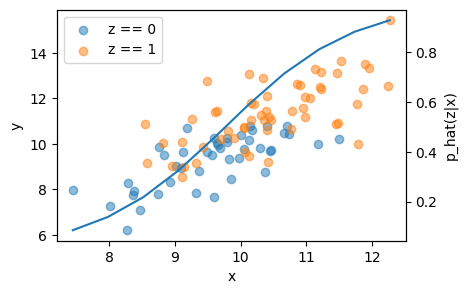

In [7]:
import numpy as np
n = 100
np.random.seed(0)
x = np.random.normal(loc=10, size=n)

s = x - x.mean()
s = (s - s.min()) / (s.max() - s.min())

z = np.random.binomial(n=1, p=s)
tau = 1
y = z * tau + x + np.random.normal(loc=0, size=n)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=[4.5,3])
ax.scatter(x[z == 0], y[z == 0], label="z == 0", alpha=0.5)
ax.scatter(x[z == 1], y[z == 1], label="z == 1", alpha=0.5)
ax.set(xlabel="x", ylabel="y")
ax.legend()

import statsmodels.api as sm
logit_res = sm.Logit(z, sm.add_constant(x)).fit(disp=0)
x_range = np.linspace(x.min(), x.max(), 10)
p_hat = logit_res.predict(sm.add_constant(x_range))

ax2 = ax.twinx()
ax2.plot(x_range, p_hat)
ax2.set(ylabel="p_hat(z|x)")

fig.show()

In [2]:
ate_naive = np.mean(y[z == 1]) - np.mean(y[z == 0])
print(f"{ate_naive=:.1f}")

p_hat = logit_res.predict(sm.add_constant(x))
y1_ipw = sum(z * y / p_hat) / sum(z / p_hat)
y0_ipw = sum( (1 - z) * y / (1 - p_hat) ) / sum( (1 - z) / (1 - p_hat) )
ate_ipw = y1_ipw - y0_ipw
print(f"{ate_ipw=:.1f}")

ate_naive=2.0
ate_ipw=1.4


In [3]:
# IPWとのつながり
# 単純な条件付き平均と同じになる
assert ( y[z==1].mean() - sum(y*z) / sum(z) ) < 10e-15

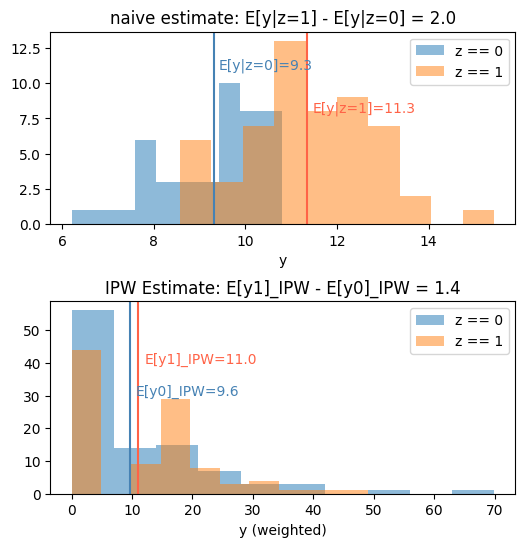

In [6]:
fig, axes = plt.subplots(nrows=2, figsize=[6, 6])
fig.subplots_adjust(hspace=0.4)

# 1: naive estimator
ax = axes[0]
ax.hist(y[z == 0], label="z == 0", alpha=.5)
ax.hist(y[z == 1], label="z == 1", alpha=.5)
ax.set(xlabel="y")
ax.legend()

y1 = np.mean(y[z == 1])
ax.axvline(y1, color="tomato")
ax.text(y1 * 1.01, 8, f"E[y|z=1]={y1:.1f}", color="tomato")
y0 = np.mean(y[z == 0])
ax.axvline(y0, color="steelblue")
ax.text(y0 * 1.01, 11, f"E[y|z=0]={y0:.1f}", color="steelblue")
ax.set(xlabel="y", title=f"naive estimate: E[y|z=1] - E[y|z=0] = {y1 - y0:.1f}")
ax.axhline(10, xmin=np.mean(y[z == 0]), xmax=np.mean(y[z == 1]), color="black")


# 2. IPW estimate
ax = axes[1]
ax.hist( y * (1-z) / (1-p_hat), label="z == 0", alpha=.5)
ax.hist( y * z / p_hat , label="z == 1", alpha=.5)
ax.set(xlabel="y (weighted)")
ax.legend()

y1 = sum(y*z / p_hat) / sum(z / p_hat)
ax.axvline(y1, color="tomato")
ax.text(y1 * 1.1, 40, f"E[y1]_IPW={y1:.1f}", color="tomato")
y0 = sum( y*(1-z) / (1-p_hat) ) / sum((1 - z) / (1-p_hat))
ax.axvline(y0, color="steelblue")
ax.text(y0 * 1.1, 30, f"E[y0]_IPW={y0:.1f}", color="steelblue")

ax.axhline(10, xmin=np.mean(y[z == 0]), xmax=np.mean(y[z == 1]), color="black")
ax.set(title=f"IPW Estimate: E[y1]_IPW - E[y0]_IPW = {y1 - y0:.1f}")

fig.show()

In [30]:
from causallib.datasets import load_nhefs
data = load_nhefs()
X, a, y = data.X, data.a, data.y

from sklearn.linear_model import LogisticRegression
from causallib.estimation import IPW

ipw = IPW(LogisticRegression(solver="liblinear", class_weight="balanced"))
ipw.fit(X, a)
potential_outcomes = ipw.estimate_population_outcome(X, a, y)
effect = ipw.estimate_effect(potential_outcomes[1], potential_outcomes[0])
effect

diff    3.411915
dtype: float64

<Axes: xlabel='Absolute Standard Mean Difference', ylabel='Covariates'>

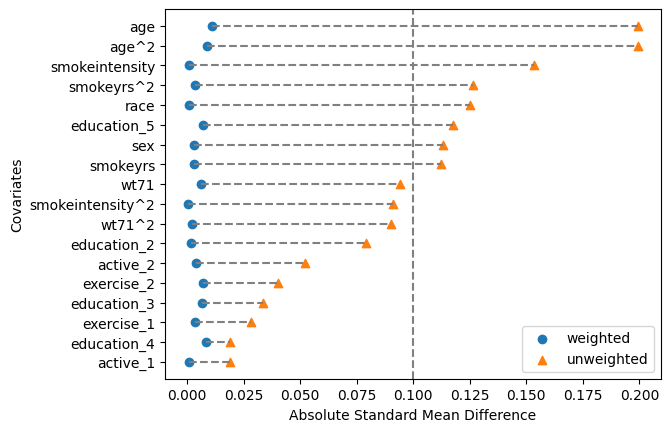

In [31]:
# love plot: 重みつけ後の共変量の絶対標準化差（ASMD）が十分小さいことを確認するplot
from causallib.evaluation import evaluate
results = evaluate(ipw, X, a, y)
results.plot_covariate_balance(thresh=0.1)

### Bayesian IPW

- Liao, Shirley X., and Corwin M. Zigler. 2020. "Uncertainty in the Design Stage of Two-Stage Bayesian Propensity Score Analysis." Statistics in Medicine 39 (17): 2265–90. https://doi.org/10.1002/sim.8486.
- Heiss, Andrew. 2021. "How to Create a(n Almost) Fully Bayesian Outcome Model with Inverse Probability Weights." December 20, 2021. https://doi.org/10.59350/gyvjk-hrx68.
- [Bayesian IPWのStan実装の紹介](https://zenn.dev/tokin_tokin/articles/55122463f4be66)


## DR推定量

傾向スコア解析の改善余地が2点ある

1. 傾向スコア推定後に結果変数の周辺分布を推定する際に$z=0$のグループの共変量の情報を用いておらず、データを無駄にしている
2. 傾向スコアを計算する際のモデルが誤った場合、推定結果が誤ったものになる可能性

これらを解決するのがDR推定量。


**二重にロバストな推定量**（doubly robust estimator)は、傾向スコアと、共変量で結果変数を説明する回帰関数を両方用いる方法

傾向スコア算出のためのモデル$p(z|\b{x}, \alpha) = e(\b{x}, \alpha)$の母数$\alpha$の一致推定量を$\hat{\alpha}$、共変量で結果変数を説明する回帰関数$E[y_1|\b{x}]=g(\b{x}, \b{\beta}_1)$の母数の推定量を$\hat{\b{\beta}}_1$とすると

$$
\begin{align}
\hat{E}^{DR}(y_1)
&= \frac{1}{N} \sum^N_{i=1} \left[
    \frac{ z_i y_i }{ e(\b{x}_i, \hat{\alpha}) }
    + \left( 1 - \frac{z_i}{ e(\b{x}_i, \hat{\alpha}) } \right)
    g(\b{x}_i, \hat{\b{\beta}}_1)
\right]
\\
&= \frac{1}{N} \sum^N_{i=1} \left[
    \frac{ z_i y_i }{ e(\b{x}_i, \hat{\alpha}) }
    - \left( \frac{z_i - e(\b{x}_i, \hat{\alpha}) }{ e(\b{x}_i, \hat{\alpha}) } \right)
    g(\b{x}_i, \hat{\b{\beta}}_1)
\right]
\\
&= \frac{1}{N} \sum^N_{i=1} \left[
    y_{i1}
    + \left( 
        \frac{ z_i - e(\b{x}_i, \hat{\alpha}) }{ e(\b{x}_i, \hat{\alpha}) }
    \right)
    \left(
        y_{i1} - g(\b{x}_i, \hat{\b{\beta}}_1)
    \right)
\right]
\end{align}
$$

となる。


以下の条件のどちらかが成立していれば、DR推定量は結果変数の周辺平均の一致推定量となる

* 条件A: 傾向スコアを計算する際に利用されるモデルが正しく指定されている
* 条件B: 共変量で結果変数を説明する回帰関数のモデルが正しく指定されている


## 共変量釣り合い傾向スコア

[Imai, K., & Ratkovic, M. (2014). Covariate balancing propensity score.](https://academic.oup.com/jrsssb/article/76/1/243/7075938)

**共変量釣り合い傾向スコア（covariate balancing propensity score：CBPS）**は、対照群・処置群の共変量の期待値が一致する（バランスする）という制約条件の下で傾向スコアを推定する方法

逆確率で重みを付けたとき、期待値がバランスしててほしい

$$
E\left[ \frac{D_i X_{ij} }{ e(\boldsymbol{X}_i) } \right]
= E\left[ \frac{(1 - D_i) X_{ij} }{ 1 - e(\boldsymbol{X}_i) } \right]
$$

推定はロジスティック回帰

$$
\log \left( \frac{e(X_i)}{1-e(X_i)} \right)
= \beta_0 + \beta_1 X_{i1} + \cdots + \beta_p X_{ip}
$$

モーメント条件

$$
\begin{align}
E\left[ \frac{D_i X_{i1} }{ e(\boldsymbol{X}_i) } - \frac{(1 - D_i) X_{i1} }{ 1 - e(\boldsymbol{X}_i) } \right]
&= 0\\
&\vdots\\
E\left[ \frac{D_i X_{ij} }{ e(\boldsymbol{X}_i) } - \frac{(1 - D_i) X_{ij} }{ 1 - e(\boldsymbol{X}_i) } \right]
&= 0
\end{align}
$$

シンプルながらもモデルの誤特定に頑健らしい

モーメント法特有の過小識別の問題はどうクリアしてる？

### causallib

## 参考文献

- [計量経済学応用 傾向スコア](https://yukiyanai.github.io/jp/classes/econometrics2/contents/R/propensity-score.html)
- [cibook_ch3_pscore](https://gist.github.com/SakumaRyoDev/309c9c6c0002145d09fd36ddfbe3613b)
- [Rosenbaum, P. R., & Rubin, D. B. (1983). The central role of the propensity score in observational studies for causal effects. Biometrika, 70(1), 41-55.](https://academic.oup.com/biomet/article/70/1/41/240879)
- Rubin, D. B. (1985). The use of propensity scores in applied Bayesian inference. Bayesian statistics, 2, 463-472.